# Tutorial

## Preliminaries

In [73]:
import sys
sys.path.append('..')

In [74]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math
import time

In [75]:
from ctrl.block.linear import ShortCircuit, Gain, Feedback, Differentiator
from ctrl.block.logger import Logger

In [76]:
from ctrl.client import Controller
#HOST, PORT = "localhost", 9999
HOST, PORT = "192.168.10.105", 9999
controller = Controller(host = HOST, port = PORT)

## Obtaining information on the system

In [77]:
controller.reset()

In [78]:
print(controller.info('all'))

> Controller with 4 device(s), 5 signal(s), 3 source(s), 1 sink(s), and 0 filter(s)
> devices
  1. encoder1[source]
  2. motor1[sink]
  3. analog1[source]
  4. clock[source]
> signals
  1. analog1
  2. clock
  3. encoder1
  4. is_running
  5. motor1
> sources
  1. clock[enabled] >> clock
  2. encoder1[enabled] >> encoder1
  3. analog1[enabled] >> analog1
> filters
> sinks
  1. motor1 >> motor1[enabled]



## Running the DC-Motor

In order to make the DC motor move we set the signal *motor1* to 100% for 5 seconds.

**IMPORTANT**: After executing the following lines the notebook interface will *freeze* for 5 seconds. You will know when you're done when the \* inside `In[*]` changes into a number and the circle on the top of the notebook turns empty again.

In [79]:
with controller:
    controller.set_signal('motor1', 100)
    time.sleep(5)

The controller runs in the background.

It *starts* as soon as the `with` is executed and *stops* immediatelly when iPython finishes
executing the `with` block.
    
We use `time.sleep(5)` to keep the `with` block running for 5 seconds.

**TASKS**: 
1. Modify the the code and set the reference to levels: 75%, 50%, 25% and 0%
2. Try a negative reference
3. Try a reference greater than 100%

**QUESTIONS**:
1. How does the motor respond to changes in the reference?
2. How does the motor respond to small references? Can you explain it?
3. Which physical quantity does *reference* control?

## Attaching a Logger and Retrieving Data

If you want to inspect the data collected when you run the motor you will need to attach a *Logger* to controller. The *Loger* is a **sink**, that is, it is a block that has only inputs and produces no output in the control algorithm. We use the following code to attach a *Logger* to the controller:

In [80]:
controller.add_sink('logger', Logger(auto_reset = True), ['clock', 'encoder1'])

This command means that a *Logger* named *logger* is been attached to the controller as a sink and its inputs are the signal *clock* and *encoder1*. This *Logger* will record the time (*clock*) and the motor position (*encoder*).

Let us verify that the *logger* is now part of the controller:

In [81]:
print(controller.info('all'))

> Controller with 4 device(s), 5 signal(s), 3 source(s), 2 sink(s), and 0 filter(s)
> devices
  1. encoder1[source]
  2. motor1[sink]
  3. analog1[source]
  4. clock[source]
> signals
  1. analog1
  2. clock
  3. encoder1
  4. is_running
  5. motor1
> sources
  1. clock[enabled] >> clock
  2. encoder1[enabled] >> encoder1
  3. analog1[enabled] >> analog1
> filters
> sinks
  1. motor1 >> motor1[disabled]
  2. clock, encoder1 >> logger[enabled]



After attaching the *Logger* we need to run the motor again to generate some data:

In [82]:
with controller:
    controller.set_signal('motor1', 100)
    time.sleep(5)

We access the data by *reading* the *sink* named *logger*:

In [83]:
log = controller.read_sink('logger')

The data is imported from the controller as a *numpy array* which we label `log`. 

The array `log` is organized in columns as folows:

clock (s) | encoder1 (cycles)
:----: | :---:
0.0  | 0.0
0.1  | 0.2
... | ... 

We will use matplotlib to plot the data:

<IPython.core.display.Javascript object>


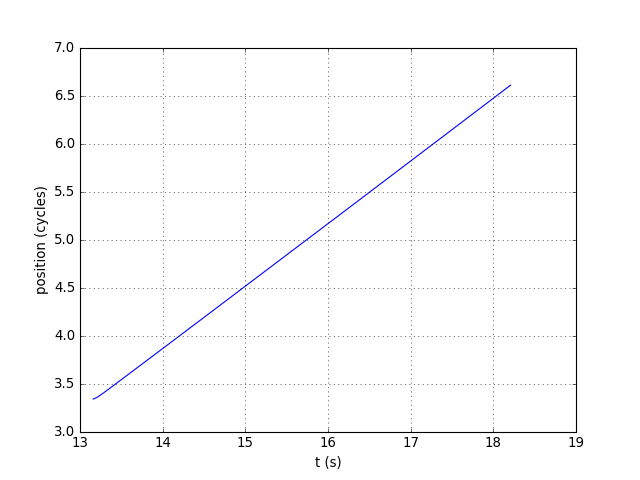

In [84]:
t = log[:,0]
position = log[:,1]

fig1 = plt.figure()

plt.plot(t, position)
# the next lines will make the plot look nicer
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()

### Calculating the velocity

Once we have imported the data from the controller box we can easily calculate other quantities using numpy.

For example we can calculate and plot the velocity using the following code:

<IPython.core.display.Javascript object>


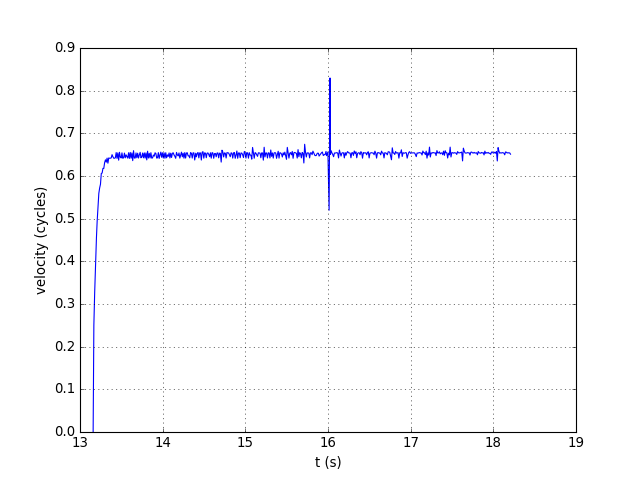

In [85]:
velocity = np.zeros(position.shape)
velocity[1:] = (position[1:] - position[:-1])/(t[1:]-t[:-1])

fig2 = plt.figure()

plt.plot(t, velocity)
plt.xlabel('t (s)')
plt.ylabel('velocity (cycles)')
plt.grid()

**TASKS**: 
1. Write python code that resets the controller logger, sets the reference at 50% for 2 seconds then at 0% for 1/2 second and -50% for 2 more seconds then import the data and plot the result using matplotlib

**QUESTION**:
1. How does the motor respond to different constant *reference*?


## Measuring velocity

You will now add a device that will calculate the velocity by numerically differentiating the encoder reading. We first add a signal:

In [86]:
controller.add_signal('velocity1')

then a **Differentiator** *filter*:

In [87]:
controller.add_filter('velocity1', Differentiator(), ['clock', 'encoder1'], ['velocity1'])

A *filter* takes inputs and produces outputs. In this case the inputs are the clock and the encoder1 signals, and the output is the velocity1 signal.

We also modify the logger to read the `velocity1` signal:

In [91]:
controller.add_sink('logger', Logger(auto_reset = True), ['clock', 'encoder1','velocity1'])

The `velocity1` *filter* and the new logger are now part of the controller:

In [92]:
print(controller.info('all'))

> Controller with 4 device(s), 6 signal(s), 3 source(s), 2 sink(s), and 1 filter(s)
> devices
  1. encoder1[source]
  2. motor1[sink]
  3. analog1[source]
  4. clock[source]
> signals
  1. analog1
  2. clock
  3. encoder1
  4. is_running
  5. motor1
  6. velocity1
> sources
  1. clock[enabled] >> clock
  2. encoder1[enabled] >> encoder1
  3. analog1[enabled] >> analog1
> filters
  1. clock, encoder1 >> velocity1[enabled] >> velocity1
> sinks
  1. motor1 >> motor1[disabled]
  2. clock, encoder1, velocity1 >> logger[enabled]



We run the motor again and read the logger:

In [95]:
with controller:
    controller.set_signal('motor1', 100)
    time.sleep(5)
log = controller.read_sink('logger')

then plot the velocity as read from the controller:

<IPython.core.display.Javascript object>


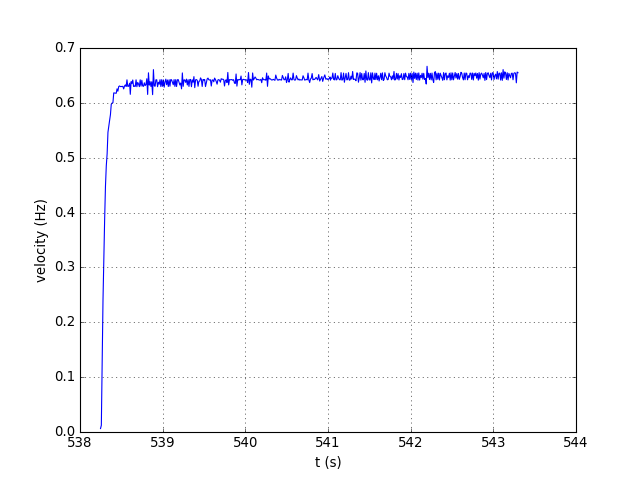

In [96]:
t = log[:,0]
position = log[:,1]
velocity = log[:,2]

fig1 = plt.figure()

plt.plot(t, velocity)
# the next lines will make the plot look nicer
plt.xlabel('t (s)')
plt.ylabel('velocity (Hz)')
plt.grid()

## Interactive Plotting

In [156]:
def add_data(ax, x, y):
    for line in ax.lines:
        xx, yy = line.get_data()
        x = np.append(xx, x)
        y = np.append(yy, y)
        line.set_data(x, y)
        #print('x = {}\ny = {}'.format(x,y))
    ax.set_ylim(np.min(y),np.max(y))
    ax.set_xlim(x[0],x[-1])
    fig.canvas.draw()

<IPython.core.display.Javascript object>


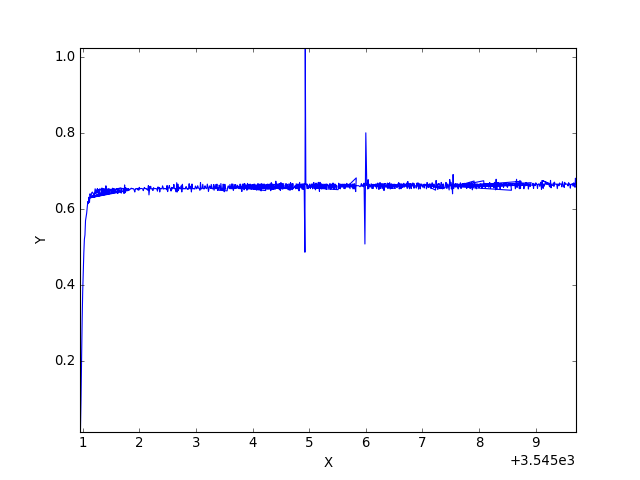

In [162]:
fig, ax = plt.subplots(1,1)
plt.plot([],[])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(0,1)
ax.set_ylim(0,1)

controller.set_sink('logger',reset=True)
with controller:
    controller.set_signal('motor1', 100)
    for f in range(50):
        time.sleep(.1)
        log = controller.read_sink('logger')
        add_data(ax, log[:,0], log[:,2])

### Interacting with iPython widgets

We can use iPython widgets to interact with the controller.

For example we can create a slider that will set the reference for us.

In [ ]:
from IPython.display import display
import ipywidgets as widgets

def set_reference(value):
    controller.set_signal('motor1',value)
    
w = widgets.interactive(set_reference, value=(-100,100))
display(w)

Try moving the slider as you `start` the controller.

In [ ]:
controller.set_sink('logger', reset=True)
controller.start()
controller.set_signal('motor1',0)

Don't forget to manually `stop` the controller since we are not using a `with` block:

In [ ]:
controller.stop()

### Using the potentiometer

We can activate the potentiometer in the controller hardware by setting `reference_mode` to 1 instead of the default 0.

In [ ]:
controller.add_filter('analog1', ShortCircuit(), ['analog1'], ['motor1'])

In [ ]:
print(controller.info('all'))

Then run the controller for 10s while changing the potentiometer in the controller box:

In [ ]:
with controller:
    time.sleep(15)

Simply remove the *ShortCircuit* to go back to the previous behaviour

In [ ]:
controller.remove_filter('analog1')

## Interactive plots

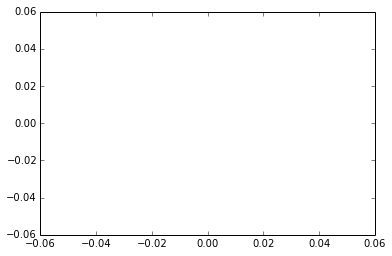

In [39]:
hl, = plt.plot([], [])

def update_line(hl, new_data):
    hl.set_xdata(numpy.append(hl.get_xdata(), new_data))
    hl.set_ydata(numpy.append(hl.get_ydata(), new_data))
    plt.draw()

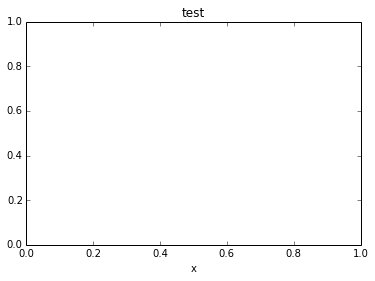

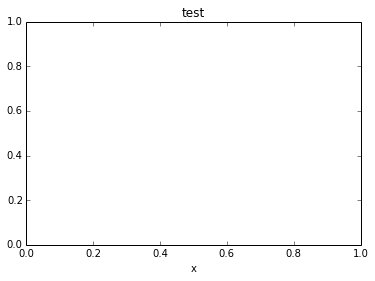

In [63]:
def update_line(num, data, line):
    line.set_data(data[..., :num])
    display(fig1)
    return line,

fig1 = plt.figure()

data = np.random.rand(2, 25)
l, = plt.plot([], [], 'r-')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('x')
plt.title('test')
line_ani = animation.FuncAnimation(fig1, update_line, 25, fargs=(data, l),
                                   interval=50, blit=True)

In [58]:
from ipywidgets import interact
from IPython.display import clear_output, display, HTML

In [46]:
# 1. Using interact as a function
def square(num=1):
    print("{} squared is {}".format(num, num*num))
interact(square, num=5)

11 squared is 121


In [48]:
@interact
def square(num=2):
    print("{} squared is {}".format(num, num*num))

0 squared is 0


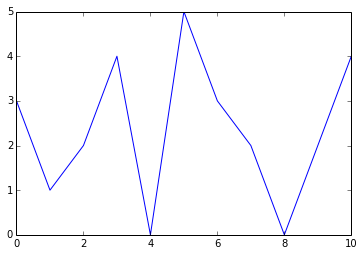

In [49]:
fig, ax = plt.subplots() 
ax.plot([3,1,2,4,0,5,3,2,0,2,4])

In [59]:
vline = ax.axvline(1)
hline = ax.axhline(0.5)

def set_cursor(x, y):
    vline.set_xdata((x, x))
    hline.set_ydata((y, y))
    display(fig)

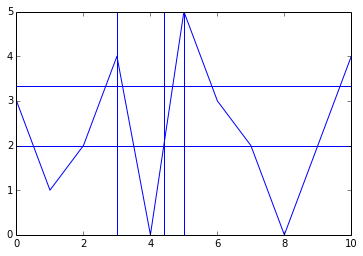

In [60]:
interact(set_cursor, x=(1, 9, 0.01), y=(0, 5, 0.01))